# クラスタリング
最適化問題として分類を行ってクラスタに分けます。

## 今回学ぶこと
1. 量子アニーリングでのクラスタリング
2. QAOAでのクラスタリング

## Blueqatのインストール
pipからBlueqatをインストールします。今回はobaqも使います。

In [91]:
!pip install blueqat obaq

  Running setup.py bdist_wheel for obaq ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/02/53/e8/9fb845068fabcc484f785a1b36f63c271a1c72ed9c03e599d6
Successfully built obaq
dwave-cloud-client 0.7.2 has requirement click>=7.0, but you'll have click 6.7 which is incompatible.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## 概要
最適化問題におけるクラスタリングは、

青はクラスタ、赤は量子ビット、黒の太い線は赤い量子ビットの３つのうちどれかが選ばれるように選ばれます。黄色は距離などでノード間の重み付けに使います。

今回はランダムに設定した点をD-WaveのLeap2でクラスタリングしてみたいと思います。

## 例題
4ノードを2つのクラスタに分けます。必要な量子ビット数は4*2=8です。q0,q1,q2,q3とq4,q5,q6,q7の二つのクラスタを作り、q0とq4、q1とq5、q2とq6、q3とq7は同じノードを表し、所属する方のクラスタの値が1になり、それ以外は0になります。

ノードとエッジは例題の途中のネットワーク図1を参照します。

クラスタ内のノード間の距離の総数の小さい方が選ばれます。
$$
Cost = \sum d_{ij} x_i x_j
$$

制約条件は、クローンされたクラスタのうち対応するノード1つだけが1となり、残りは0になります。
$$
Constraint = \sum(\sum_{i=k}^n x_i - 1)^2
$$

まず、ツール読み込みます。

In [127]:
import numpy as np
import pandas as pd
import networkx as nx
from blueqat.opt import *
import matplotlib.pyplot as plt
%matplotlib inline

まず、データを作ります。今回は4ノードを2クラスタに分ける簡単な問題をやってみます。

In [128]:
n_node = 4
n_cluster = 2
N = n_node*n_cluster

print('nodes',n_node)
print('clusters',n_cluster)
print('qubits',N)

nodes 4
clusters 2
qubits 8


程よくばらけるように座標でデータを作ります。

In [129]:
x,y = [],[]

for i in range(n_cluster):
    x = np.append(x, np.random.normal(np.random.randint(0,n_cluster*10), 1.5, int(n_node/n_cluster)))
    y = np.append(y, np.random.normal(np.random.randint(0,n_cluster*10), 1.5, int(n_node/n_cluster)))

df = pd.DataFrame({'x':x,'y':y})
df

,x,y
0,17.185806,8.627046
1,18.668083,10.208109
2,3.824307,12.236875
3,6.172536,10.587912


作った座標の点の分布を確認します。

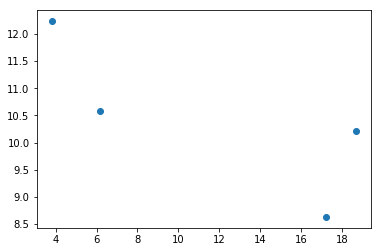

In [130]:
#plot
plt.scatter(df['x'], df['y'])

まず距離を設定したQUBO matrixを準備します。

In [131]:
def initCost(data, n_cluster):
    #距離の行列を作ります。
    n_node = len(data)
    d = np.zeros((n_node, n_node))

    #データのX座標とY座標から距離を求めます。
    for i in range(0, n_node-1):
        for j in range(i+1, n_node):
            a = np.array([data['x'][i], data['y'][i]])
            b = np.array([data['x'][j], data['y'][j]])
            d[i][j] = np.linalg.norm(a-b)

    #QUBO matrixは量子ビット数*量子ビット数のサイズになります。
    N = n_node*n_cluster
    A = np.zeros((N, N))

    #クラスタの数だけ距離を複製して入れます。
    for i in range(0, n_node-1):
        for j in range(i+1, n_node):
            for k in range(n_cluster):
                A[i+k*n_node][j+k*n_node] = d[i][j]
    
    return A, d

In [132]:
A,d = initCost(df, n_cluster)
A

array([[ 0.        ,  2.16723441, 13.84053936, 11.18646999,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 14.98177572, 12.50131812,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  2.86936555,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         2.16723441, 13.84053936, 11.18646999],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 14.98177572, 12.50131812],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  2.86936555],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

今回はそれぞれ$q_0$と$q_4$,$q_1$と$q_5$,$q_2$と$q_6$,$q_3$と$q_7$の間に制約条件を設定します。どちらかのクラスタにしか属さないので、それぞれの値のどちらかが1で、どちらかが0になります。

$$
(q_0+q_4 - 1)^2 = -q_0-q_4+2q_0q_4\\
(q_1+q_5 - 1)^2 = -q_1-q_5+2q_1q_5\\
(q_2+q_6 - 1)^2 = -q_2-q_6+2q_2q_6\\
(q_3+q_7 - 1)^2 = -q_3-q_7+2q_3q_7\\
$$

In [133]:
B = np.diag([-1]*N)

for i in range(n_node):
    B[i][i+n_node] = 2
B

array([[-1,  0,  0,  0,  2,  0,  0,  0],
       [ 0, -1,  0,  0,  0,  2,  0,  0],
       [ 0,  0, -1,  0,  0,  0,  2,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  2],
       [ 0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  0],
       [ 0,  0,  0,  0,  0,  0, -1,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1]])

ネットワーク図1


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


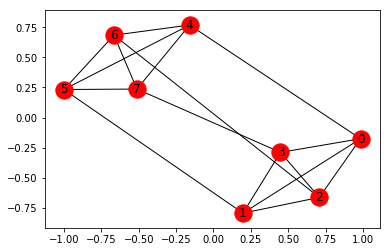

In [134]:
#QUBOを作ります。
M = 1
qubo = A+B*M

#ネットワーク図で確認
G = nx.from_numpy_matrix(qubo)
nx.draw_networkx(G)
plt.show()

Mの値を決めて計算をします。

In [135]:
#blueqatで
M = 10
qubo = A+B*M

a = Opt()
a.qubo = qubo
res = a.run()

res

[0, 0, 1, 1, 1, 1, 0, 0]

計算結果を確認してみます。

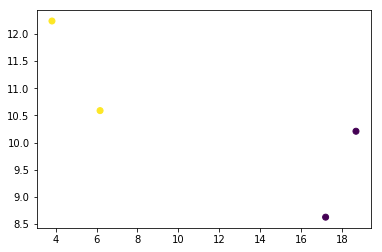

In [145]:
df['cluster'] = res[:4]
plt.scatter(df['x'], df['y'], c=df['cluster'])

## 次にQAOAで解いてみます

In [146]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import blueqat
from blueqat import vqe,opt
from obaq.ansatz import *

%matplotlib inline

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


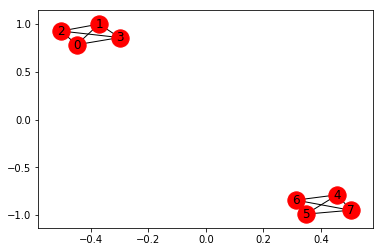

In [147]:
#QUBOを作ります。
qubo = A

#ネットワーク図で確認
G = nx.from_numpy_matrix(qubo)
nx.draw_networkx(G)
plt.show()

今回は制約条件はいりません。

制約条件をミキサーで決めます。
1. 初期のもつれを決める
2. XYミキサーを作る

In [148]:
q = opt.pauli(qubo)
step = 2

#mixer and init state
for i in range(n_node):
    if i==0:
        mixer = 0.5*X[0]*X[n_node] + 0.5*Y[0]*Y[n_node]
        init = Circuit().h[0].cx[0,n_node].x[0]
    else:
        mixer += 0.5*X[i]*X[i+n_node] + 0.5*Y[i]*Y[i+n_node]
        init.h[i].cx[i,i+n_node].x[i]

print(mixer)
print(init)

result = Vqe(QaoaQaoaAnsatz(q, step, init, mixer)).run()
res_qaoa = result.most_common(1)[0][0]
res_qaoa

0.5*X[0]*X[4] + 0.5*Y[0]*Y[4] + 0.5*X[1]*X[5] + 0.5*Y[1]*Y[5] + 0.5*X[2]*X[6] + 0.5*Y[2]*Y[6] + 0.5*X[3]*X[7] + 0.5*Y[3]*Y[7]
Circuit(8).h[0].cx[0, 4].x[0].h[1].cx[1, 5].x[1].h[2].cx[2, 6].x[2].h[3].cx[3, 7].x[3]


(0, 0, 1, 1, 1, 1, 0, 0)

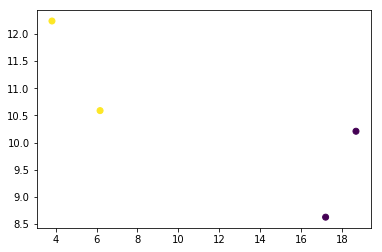

In [149]:
resc = []

for i in range(N):
    if res_qaoa[i] == 1:
        resc.append(int(i/n_node))

df['cluster_qaoa'] = resc

plt.scatter(df['x'], df['y'], c=df['cluster_qaoa'])

In [150]:
result.circuit

Circuit(8).h[0].cx[0, 4].x[0].h[1].cx[1, 5].x[1].h[2].cx[2, 6].x[2].h[3].cx[3, 7].x[3].cx[0, 1].rz(-23.13118889729867)[1].cx[0, 1].cx[0, 2].rz(-147.72196729110493)[2].cx[0, 2].cx[0, 3].rz(-119.39472239286386)[3].cx[0, 3].rz(290.24787858126746)[0].cx[1, 2].rz(-159.90253883786704)[2].cx[1, 2].cx[1, 3].rz(-133.42827602112513)[3].cx[1, 3].rz(316.4620037562908)[1].cx[2, 3].rz(-30.625130524539596)[3].cx[2, 3].rz(338.2496366535116)[2].rz(283.44812893852855)[3].cx[4, 5].rz(-23.13118889729867)[5].cx[4, 5].cx[4, 6].rz(-147.72196729110493)[6].cx[4, 6].cx[4, 7].rz(-119.39472239286386)[7].cx[4, 7].rz(290.24787858126746)[4].cx[5, 6].rz(-159.90253883786704)[6].cx[5, 6].cx[5, 7].rz(-133.42827602112513)[7].cx[5, 7].rz(316.4620037562908)[5].cx[6, 7].rz(-30.625130524539596)[7].cx[6, 7].rz(338.2496366535116)[6].rz(283.44812893852855)[7].h[0].h[4].cx[0, 4].rz(-38.25828713614918)[4].cx[0, 4].h[0].h[4].h[1].h[5].cx[1, 5].rz(-38.25828713614918)[5].cx[1, 5].h[1].h[5].h[2].h[6].cx[2, 6].rz(-38.25828713614918)[6